## Advanced Topics in Computional Intelligence
### Advantage Actor Critic Implementation
*Natalia Jakubiak*

This work is structured as 2 isolated jupyter notebooks: 
* a2c_cartpole_report.ipynb - contains the description of an implementation (report) and solution for OpenAI problem "CartPole-V1"
* a2c_lunarlander.ipynb - contains solution for "LunarLander-v2" problem

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import matplotlib.pyplot as plt
import collections

#### Lunar Lander problem

The LunarLander-v2 is the discrete version of unar Lander Environment in OpenAIGym. 

*Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.*

**The problem is considered "solved" when the average total reward for the episode reaches 200 over 100 consecutive trials.**

---



In [2]:
!pip install Box2D

     |████████████████████████████████| 1.3MB 6.2MB/s 


In [3]:
# load environment
env = gym.make('LunarLander-v2')

In [4]:
# get size of state and action from environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n


In [5]:
# set seed for experiment reproducibility
SEED = 44
env.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [6]:
# parameters for learning
discounted_factor = 0.99
actor_lr = 0.001
critic_lr = 0.001
EPISODES = 5000

#### Agent architecture

The architecture for Actor-Critic networks for this problem is more complex than for a CartPole one. It contains one more dense layer of 16 hidden units.

In [7]:
class Actor(nn.Module):
    def __init__(self, n_action, space_dim, hidden_dim):
        super(Actor, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(space_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),

        )
        self.actor = nn.Sequential(
            nn.Linear(16, n_action),
            nn.Softmax(dim=-1),
        )
    
    def forward(self, x):
        features = self.feature_extractor(x)
        policy = self.actor(features)
        return policy
    
class Critic(nn.Module):
    def __init__(self, space_dim, hidden_dim):
        super(Critic, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(space_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),

        )
        self.critic = nn.Linear(16, 1)
    
    def forward(self, x):
        features = self.feature_extractor(x)
        est_reward = self.critic(features)
        return est_reward

In [8]:
# Actor loss function (policy gradient method loss)
# Equivalent of tensorflow equation: loss = - tf.reduce mean(tf.log(prob outputs) * reward) [Source: ATCI presentation, Policy gradient methods, slide 34 ]
class PGLoss(nn.Module):
    def __init__(self):
        super(PGLoss, self).__init__()
    
    def forward(self, action_prob, reward):
        loss = -torch.mean(torch.log(action_prob+1e-6)*reward)
        return loss

In [9]:
# Using the output of policy network, pick action stochastically
def get_action(policy):
    return np.random.choice(len(policy), 1, p=policy)[0]

In [10]:
# Return a new tensor with a dimension of size one inserted at the specified position
def to_tensor(x, dtype=None):
    return torch.tensor(x, dtype=dtype).unsqueeze(0)

In [11]:
# Actor loss function
pg_loss = PGLoss()
# Critic loss function
mse_loss = nn.MSELoss()

In [12]:
# Create actor and critic networks
actor = Actor(action_size, state_size, hidden_dim)
critic = Critic(state_size, hidden_dim)

In [13]:
# Add Adam Optimizer training for both the actor and critic functions, each with their own learning rate
actor_optim = torch.optim.Adam(actor.parameters(), lr=actor_lr)
critic_optim = torch.optim.Adam(critic.parameters(), lr=critic_lr)

In [14]:
scores_dq = collections.deque(maxlen=100)
reward_lst = []
avg_reward_lst = []

for e in range(EPISODES):
    done = False
    score = 0
    state = to_tensor(env.reset(), dtype=torch.float)
    score = 0
    while not done:
        actor_optim.zero_grad()
        critic_optim.zero_grad()
        
        policy = actor(state)
        action = get_action(policy.detach().numpy()[0])
        
        next_state, reward, done, info = env.step(action)
        
        next_state = to_tensor(next_state, dtype=torch.float)
        advantages = torch.zeros_like(policy)
        
        value = critic(state)[0]
        next_value = critic(next_state)[0]
        if done:

            t_reward = to_tensor([reward], dtype=torch.float)
            advantages[0, action] = t_reward - value
            target = t_reward
        else:
            t_reward = to_tensor([reward], dtype=torch.float)
            advantages[0, action] = t_reward + discounted_factor*next_value - value
            target = t_reward + discounted_factor*next_value
        
        state = next_state
        actor_loss = pg_loss(policy, advantages.detach())
        critic_loss = mse_loss(value, target.detach())
        loss = actor_loss + critic_loss
        loss.backward()
        actor_optim.step()
        critic_optim.step()
        
        if not done:
            score += reward
    scores_dq.append(score)
    reward_lst.append(score)
    mean_score = np.mean(scores_dq)
    avg_reward_lst.append(mean_score)
    if mean_score >= 200 and e >= 100:
        print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))    
        break
    print('Episodes: {}, Average Reward: {:.3f}, Reward: {}'.format(e, mean_score, score))



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Streaming output truncated to the last 5000 lines.
Episodes: 0, Average Reward: -242.534, Reward: -242.53389442535408
Episodes: 1, Average Reward: -163.117, Reward: -83.70058127953409
Episodes: 2, Average Reward: -146.424, Reward: -113.03866689816961
Episodes: 3, Average Reward: -222.399, Reward: -450.3216487867806
Episodes: 4, Average Reward: -218.732, Reward: -204.0665751090677
Episodes: 5, Average Reward: -237.384, Reward: -330.64551415403344
Episodes: 6, Average Reward: -236.895, Reward: -233.95497924880294
Episodes: 7, Average Reward: -211.761, Reward: -35.82835196767715
Episodes: 8, Average Reward: -201.068, Reward: -115.51752341262352
Episodes: 9, Average Reward: -184.755, Reward: -37.94109994031453
Episodes: 10, Average Reward: -175.531, Reward: -83.29079819957704
Episodes: 11, Average Reward: -200.107, Reward: -470.44086834515997
Episodes: 12, Average Reward: -184.811, Reward: -1.25988314491706
Episodes: 13, Average Reward: -185.664, Reward: -196.7500773966117
Episodes: 14, Av

#### Results

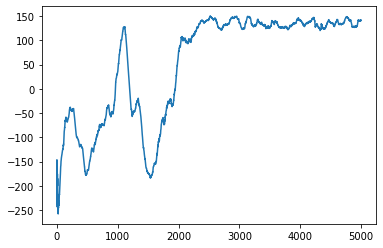

In [15]:
plt.plot(avg_reward_lst)
plt.show()

Above plot is for the average score of 100 consecutive trials for 5000 episodes.

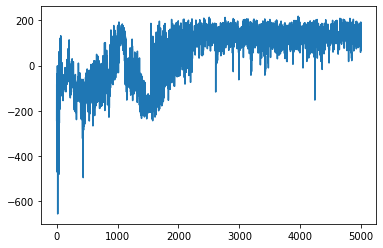

In [16]:
plt.plot(reward_lst)
plt.show()

Above plot shows exact value of the rewards for 5000 trials.

The model seems to converge at about 2000 episodes, but it gets stuck at around 150 scores and the problem stays not solved. This is because the signal from the environment is too limited for the network to learn. It then becomes
obvious that this algorithm can not be adopted outof-the-box, and for lunar lander problem it should be tailored. 
As shown in the article *Solving The Lunar Lander Problem under Uncertainty using Reinforcement Learning* written by Gadgil, Soham & Xin, Yunfeng & Xu, Chengzhe (2020) the better choice for this problem are algorithms which perform well with noisy observations. This is understandable since the noisy observations affect the underlying state space and the agent isn’t able to generalize information from its environment during training. For example the POMDP agent performs well with noisy observations and is able to get
positive average rewards since it makes use of belief vectors
to model a distribution over the possible states.

The good idea may be also to solve this problem using N-step AAC. The reason is that with larger N than 1, it will take more reward signal from environment into account to compute the advantage target, leading to a more accurate target, whereas for smaller N, it has to estimate based on another estimate, and more variance from the Q approximation is introduced.
